In [39]:
import numpy as np
np.set_printoptions(suppress = True)
import qiskit as qk
from qiskit import Aer, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
import time
from qiskit import QuantumCircuit

In [104]:
def CRnU(circuit, control, target, ancilla):
    #match shape to the one from the paper
    # circuit.swap(control, target)

    circuit.cnot(ancilla, target)
    circuit.cnot(control, target)
    circuit.h(ancilla)
    circuit.t(control)
    circuit.tdg(target)
    circuit.t(ancilla)
    circuit.cnot(ancilla, target)
    circuit.cnot(control, ancilla)
    circuit.t(target)
    circuit.cnot(control, target)
    circuit.tdg(ancilla)
    circuit.tdg(target)
    circuit.cnot(control, ancilla)
    circuit.cnot(ancilla, target)
    circuit.t(target)
    circuit.h(ancilla)
    circuit.cnot(ancilla, target)

    #swap back
    # circuit.swap(control, target)

def ZeroAncCRn(circuit, control, target, theta):
    # not working so far
    circuit.p(theta/2, control)
    circuit.p(theta/2, target)
    circuit.cnot(control, target)
    circuit.p(-theta/2, target)
    circuit.cnot(control, target)

In [83]:
def CRnGate(circuit, control, target, ancilla, theta):
    CRnU(circuit, control, target, ancilla)
    circuit.p(theta, ancilla)
    CRnU(circuit, control, target, ancilla)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def AFTerror(qc2, n, qft_counts, delta, backend="simulator"):
    # returns a correlation coefficient between the qft and aft signals
    aft_counts = simulate(qc2, n, display_bool=True, delta=delta, backend=backend)
    qft_results = np.zeros(len(qft_counts))
    aft_results = np.zeros(len(qft_counts))

    for i in range(len(qft_counts)):
        bin_key = "{0:b}".format(i).zfill(n)
        qft_results[i] = qft_counts.get(bin_key, 0)
        aft_results[i] = aft_counts.get(bin_key, 0)
    # return np.corrcoef(qft_results, aft_results)
    # return cdist(qft_results, aft_results)**2
    mae = np.abs(np.subtract(qft_results, aft_results)).mean()
    return mae

def compareAFT(n, qft_counts, backend="simulator"):
    errors = []
    for d in range(1, n+1):
        print("progress: {}%".format(d/n*100))
        qcAFT = QuantumCircuit(2 * n - 1, n)
        qcAFT.h(n//2)
        QFT(qcAFT, n, delta=d)
        errors.append(AFTerror(qcAFT, n, qft_counts, d, backend=backend))
        # plt.scatter(d, errors[d-1], c="#801811")
        print("d={}, errors[d-1] = {}".format(d, errors[d-1]))
        # plt.savefig("error{}.png".format(n))
    return errors

def QFT(circuit, n, delta=10000):
    swap_registers(circuit, n)
    for i in range(n):
        # print("Progress: {}".format(i/n*100))
        circuit.h(i)
        for j in range(1, n-i):
            if j < delta:
                # print("i = {}, j = {}".format(i, j))
                # print("UROT({}, {}, {})".format(j+i, i, n+i))
                CRnGate(circuit, i+j, i, n+i, np.pi/2**(j))
                # ZeroAncCRn(circuit, i, i+j, np.pi/2**(j))
            else:
                pass

In [84]:
def simulate(qc, n, reps=2**14, display_bool=False, delta=10000, backend="simulator",
    noise = 0.01):
    # Create an empty noise model
    noise_model = NoiseModel()

    # Add depolarizing error to all single qubit u1, u2, u3 gates
    error = depolarizing_error(noise, 1)
    noise_model.add_all_qubit_quantum_error(error, ['h', 't', 'cnot', 'tdg'])

    # Print noise model info
    print(noise_model)
    qc.measure(range(n), range(n))
    if backend == "simulator":
        # simulator = Aer.get_backend('qasm_simulator')
        simulator = AerSimulator(noise_model=noise_model)
        job_sim = simulator.run(qk.transpile(qc, simulator), shots=reps)
        result_sim = job_sim.result()
        counts = (result_sim.get_counts(qc))
        if display_bool:
            # choose appropriate filename
            filename = "charts/n={},delta={},noise={}.png".format(n, delta if delta < 9000 else "infinite", noise)
            plot_histogram(counts, legend=[], bar_labels=False, title="n={}, delta={}".format(n, delta if delta < 9000 else "infinite"), filename=filename)
            hist = plot_histogram(counts, legend=[], bar_labels=False, title="n={}, delta={}".format(n, delta if delta < 9000 else "infinite"))
            display(hist)
        return counts
    elif backend == "statevector":
        backend = Aer.get_backend('statevector_simulator') # the device to run on
        result = backend.run(qk.transpile(qc, backend)).result()
        psi  = result.get_statevector(qc)
        if display_bool:
            filename = "charts/hinton,n={},delta={}.png".format(n, delta if delta < 9000 else "infinite")
            plot_state_hinton(psi, filename=filename)
            state = Statevector(qc)
            plot_state_city(state, alpha=0.6)
     # print(counts)

In [85]:
b = 16
qasm_qc = QuantumCircuit(2 * b - 1, b)
QFT(qasm_qc, b, delta=8)
qasm_output = qasm_qc.qasm()

In [18]:
with open("qasm_files/qasm{}qubit".format(b), 'w') as txt_file:
    txt_file.write(qasm_output)

In [ ]:
def compareFTs(n_low, n_high, backend="simulator"):
    # heatmap showing comparative error
    heatmap = np.zeros((n_high, (n_high-n_low)//2+1))


    print("shape of heatmap: {} x {}".format(heatmap.shape[0], heatmap.shape[1]))
    i = 0
    for n in range(n_low, n_high+1, 2):
        print("n={}, i={}".format(n, i))
        qcQFT = QuantumCircuit(2 * n - 1, n)
        qcQFT.h(n//2)
        QFT(qcQFT, n)
        qft_counts = simulate(qcQFT, n, display_bool=True, backend=backend)
        start_time = time.time()
        errors = compareAFT(n, qft_counts, backend=backend)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("errors = {}".format(errors))
        for d in range(0, n):
            heatmap[d][i] = errors[d]
        i -=- 1

    print(np.around(heatmap, 3))
    plt.xlabel("n")
    plt.ylabel("delta")
    plt.imshow(heatmap)
    plt.savefig("charts/heatmap-{}-{}".format(n_low, n_high))
compareFTs(4, 4, backend="simulator")

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 't', 'tdg']
  Instructions with noise: ['cnot', 'h', 'tdg', 't']
  All-qubits errors: ['h', 't', 'cnot', 'tdg']


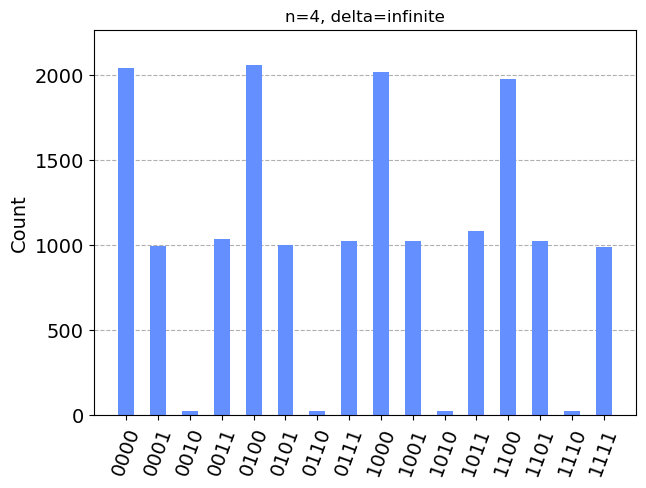

In [114]:
def QFTZeroAnc(circuit, n, delta=10000):
    swap_registers(circuit, n)
    for i in range(n):
        # print("Progress: {}".format(i/n*100))
        circuit.h(i)
        for j in range(1, n-i):
            if j < delta:
                # print("i = {}, j = {}".format(i, j))
                # print("UROT({}, {}, {})".format(j+i, i, n+i))
                ZeroAncCRn(circuit, i+j, i, np.pi/2**(j))
                # ZeroAncCRn(circuit, i, i+j, np.pi/2**(j))
            else:
                break
n=4
qcQFT = QuantumCircuit(n, n)
qcQFT.h(2)
QFTZeroAnc(qcQFT, n)
qft_counts = simulate(qcQFT, n, display_bool=True, noise=0.01)

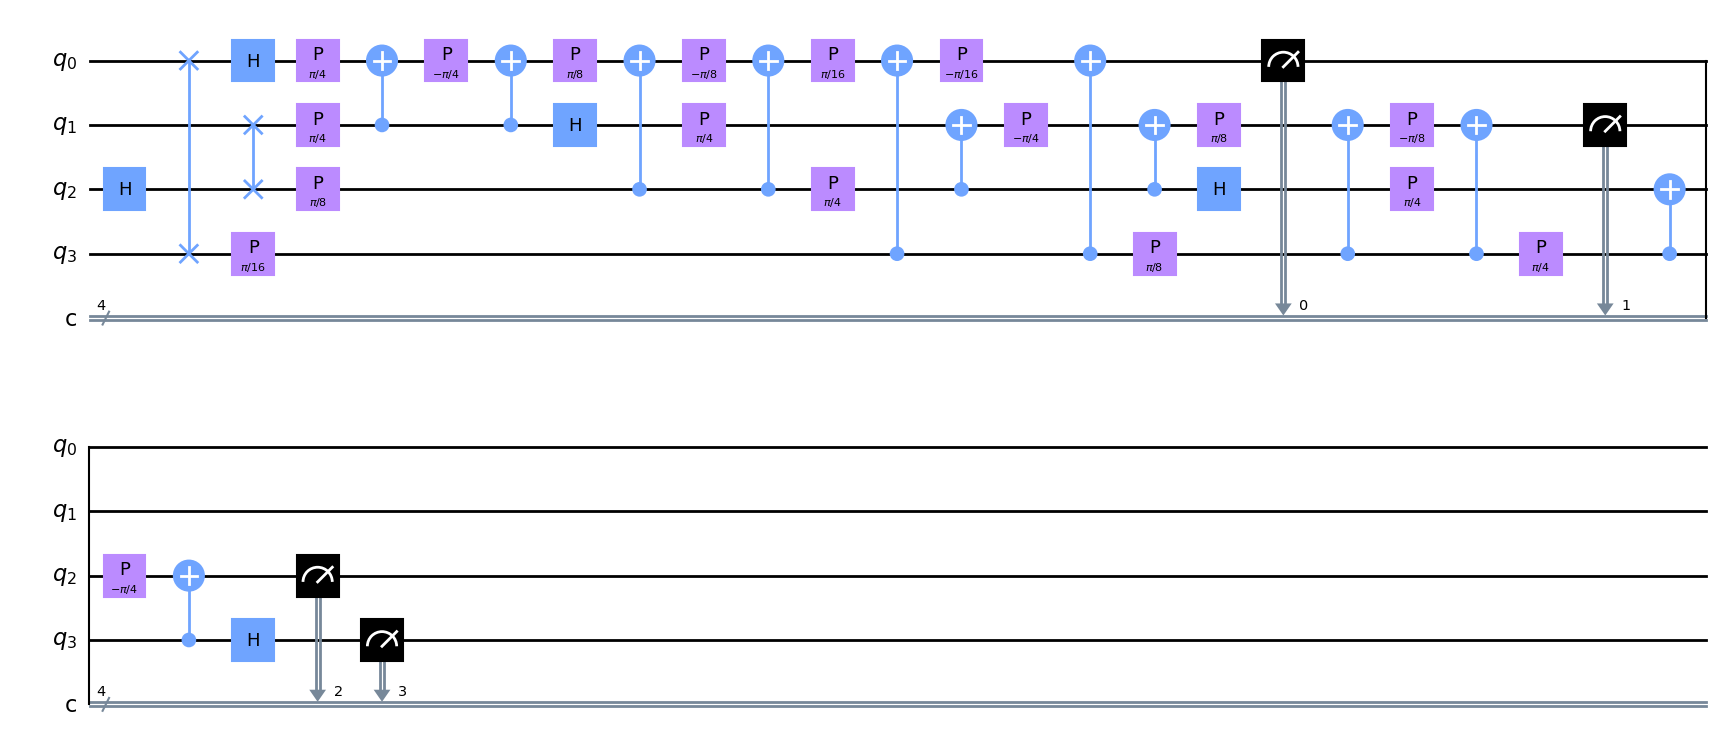

In [115]:
qcQFT.draw(output="mpl")